In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F  # Ensure this import is added

from torch.utils.data import DataLoader, TensorDataset
import gym
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2


## OSEF UN PEU DE CE QU'IL Y A ICI, DESCENDS DIRECT

In [2]:

# Parameters
sequence_length = 4  # Number of images in each sequence
num_episodes = 1000   # Number of episodes for data collection

# Environment Setup
env = gym.make('CartPole-v1')
data_images = []
data_states = []

# Transformation for images
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize image to manageable size
    transforms.ToTensor()         # Convert image to PyTorch tensor
])

def heuristic_policy(observation):
    _, _, angle, _ = observation
    return 0 if angle < 0 else 1  # Move cart based on the angle of the pole

# Data Collection using Heuristic Policy
for episode in range(num_episodes):
    observation = env.reset()
    images = []
    for t in range(1000):
        img = env.render(mode='rgb_array')
        img_pil = Image.fromarray(img)
        tensor_image = transform(img_pil)  # Transform image immediately
        images.append(tensor_image)
        
        if len(images) >= sequence_length:
            # Stack the last sequence_length images to form a single sequence tensor
            sequence_tensor = torch.stack(images[-sequence_length:], dim=0).permute(1, 0, 2, 3)
            data_images.append(sequence_tensor)
            data_states.append(observation)
        
        action = env.action_space.sample()  # Use the heuristic policy
        observation, reward, done, info = env.step(action)
        if done:
            break

env.close()

# Convert data_states to a tensor
data_states = torch.tensor(data_states, dtype=torch.float32)

# Dataset and DataLoader
dataset = TensorDataset(torch.stack(data_images), data_states)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

# Model Definition
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv3d(3, 16, kernel_size=(3, 3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)),
            nn.Conv3d(16, 32, kernel_size=(3, 3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)),
        )
        # Correctly calculate the input size for the linear layer based on the output from conv_layers
        self.fc_layers = nn.Sequential(
            nn.Linear(32 * 4 * 16 * 16, 128),  # Adjusted based on actual output size
            nn.ReLU(),
            nn.Linear(128, 4)  # Predicting 4 state variables
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor for the fully connected layer
        x = self.fc_layers(x)
        return x

# Model instantiation and training setup
model = CNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 15
for epoch in range(num_epochs):
    for images, states in dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, states)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Save the model
# torch.save(model.state_dict(), 'cartpole_cnn_test.pth')


C:\Users\hatem\AppData\Local\Temp\ipykernel_6176\4191943959.py:44: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  data_states = torch.tensor(data_states, dtype=torch.float32)


Epoch 1, Loss: 0.02815132401883602
Epoch 2, Loss: 0.06456638127565384
Epoch 3, Loss: 0.04055773839354515
Epoch 4, Loss: 0.02560395561158657
Epoch 5, Loss: 0.0548088438808918
Epoch 6, Loss: 0.04591039568185806
Epoch 7, Loss: 0.04017455503344536
Epoch 8, Loss: 0.0369737446308136
Epoch 9, Loss: 0.04050079733133316
Epoch 10, Loss: 0.03357423096895218
Epoch 11, Loss: 0.054542552679777145
Epoch 12, Loss: 0.06190171837806702
Epoch 13, Loss: 0.04005531221628189
Epoch 14, Loss: 0.02212458848953247
Epoch 15, Loss: 0.04006265848875046


In [14]:
cnn = CNN()  # Make sure CNN is defined or imported
cnn.load_state_dict(torch.load("cartpole_cnn_test.pth"))  # Load the pretrained model
cnn.eval()  # Set the model to evaluation mode

CNN(
  (conv_layers): Sequential(
    (0): Conv3d(3, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): ReLU()
    (5): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=32768, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [6]:
model.eval()
for images, states in dataloader:
    print(images.shape,states.shape)
    print(model(images[0].unsqueeze(0)),states[0])
    break

torch.Size([10, 3, 4, 64, 64]) torch.Size([10, 4])
tensor([[-0.0358, -0.5150, -0.2268, -0.4017]], grad_fn=<AddmmBackward0>) tensor([-0.0120, -0.7645, -0.1809,  0.0813])


In [7]:
torch.save(model.state_dict(), 'alors_peut_etre3.pth')

In [8]:
########## DELETE AFTER ##################

env = gym.make('CartPole-v1')
data_images_bis = []
data_states_bis = []

# Data Collection using Heuristic Policy
for episode in range(3):
    observation_bis = env.reset()
    images_bis = []
    for t in range(1000):
        img = env.render(mode='rgb_array')
        img_pil = Image.fromarray(img)
        tensor_image = transform(img_pil)  # Transform image immediately
        images_bis.append(tensor_image)
        
        if len(images_bis) >= sequence_length:
            # Stack the last sequence_length images to form a single sequence tensor
            sequence_tensor = torch.stack(images_bis[-sequence_length:], dim=0).permute(1, 0, 2, 3)
            data_images_bis.append(sequence_tensor)
            data_states_bis.append(observation)
        
        action = env.action_space.sample()   # Use the heuristic policy
        observation, reward, done, info = env.step(action)
        if done:
            break
data_states_bis = torch.tensor(data_states_bis, dtype=torch.float32)

# Dataset and DataLoader
data_images_bis = torch.stack(data_images_bis)

In [9]:
model.eval()
total = 0
for images, states in zip(data_images_bis, data_states_bis):
    with torch.no_grad():
        print(model(images.unsqueeze(0)),states)
        total += np.sum(np.array((model(images.unsqueeze(0))-states)**2))

print(total)


tensor([[-0.0203, -0.4530,  0.0361,  0.6924]]) tensor([-0.0067, -0.2081,  0.0434,  0.2850])
tensor([[-0.0117, -0.2845,  0.0232,  0.4215]]) tensor([-0.0109, -0.4038,  0.0491,  0.5910])
tensor([[-0.0267, -0.4237,  0.0442,  0.6341]]) tensor([-0.0189, -0.2094,  0.0610,  0.3142])
tensor([[-0.0274, -0.2886,  0.0732,  0.5457]]) tensor([-0.0231, -0.4053,  0.0672,  0.6255])
tensor([[-0.0368, -0.3762,  0.0642,  0.6406]]) tensor([-0.0312, -0.6013,  0.0797,  0.9386])
tensor([[-0.0641, -0.5035,  0.1270,  0.9398]]) tensor([-0.0433, -0.7974,  0.0985,  1.2552])
tensor([[-0.0661, -0.7792,  0.1252,  1.2960]]) tensor([-0.0592, -0.6037,  0.1236,  0.9949])
tensor([[-0.0634, -0.6279,  0.1437,  1.1000]]) tensor([-0.0713, -0.8002,  0.1435,  1.3237])
tensor([[-0.0670, -0.7187,  0.1556,  1.2662]]) tensor([-0.0873, -0.6072,  0.1700,  1.0792])
tensor([[-0.0870, -0.8075,  0.1654,  1.4129]]) tensor([-0.0994, -0.8041,  0.1916,  1.4200])
tensor([[-0.0144, -0.0955,  0.0325,  0.1851]]) tensor([-0.0184, -0.2069,  0.0421

In [15]:
import os

model_path = 'M1-S2\\PLDAC\\PLDAC_BBRL\\src\\cartpole_cnn_test.pth'
absolute_path = os.path.abspath(model_path)
print("Looking for model at:", absolute_path)
if not os.path.exists(absolute_path):
    print("Model file not found.")
else:
    print("Model file found.")

Looking for model at: c:\Users\hatem\OneDrive\Documents\Programmation\M1-S2\PLDAC\PLDAC_BBRL\src\M1-S2\PLDAC\PLDAC_BBRL\src\cartpole_cnn_test.pth
Model file not found.


In [16]:
import os

# Absolute path to where the model file is stored
model_path = os.path.abspath('C:/Users/hatem/OneDrive/Documents/Programmation/M1-S2/PLDAC/PLDAC_BBRL/src/cartpole_cnn_test.pth')

# Load the model
cnn.load_state_dict(torch.load(model_path))


<All keys matched successfully>

## C ICI POUR TRAIN LE MODEL COMPATIBLE AVEC IMAGEAGENT

In [2]:

# Parameters
sequence_length = 4  # Number of images in each sequence
num_episodes = 100   # Number of episodes for data collection



# Environment Setup
env = gym.make('CartPole-v1')
data_images = []
data_states = []

# Transformation for images should be correct
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize image to manageable size
    transforms.ToTensor()         # Convert image to PyTorch tensor
])

def heuristic_policy(observation):
    _, _, angle, _ = observation
    return 0 if angle < 0 else 1

# Data Collection using Heuristic Policy
for episode in range(num_episodes):
    observation = env.reset()
    images = []
    for t in range(1000):
        img = env.render(mode='rgb_array')
        img_pil = Image.fromarray(img)
        tensor_image = transform(img_pil)  # Transform image immediately
        images.append(tensor_image)
        
        if len(images) >= sequence_length:
            # Stack the last sequence_length images to form a single sequence tensor
            sequence_tensor = torch.stack(images[-sequence_length:], dim=0)  # Dimension [sequence_length, 3, 64, 64]
            data_images.append(sequence_tensor.permute(1, 0, 2, 3))  # Rearrange to [3, sequence_length, 64, 64]
            data_states.append(observation)
        
        action = heuristic_policy(observation)
        observation, reward, done, info = env.step(action)
        if done:
            break

env.close()

# Convert data_states to a tensor
data_states = torch.tensor(data_states, dtype=torch.float32)

# Dataset and DataLoader
dataset = TensorDataset(torch.stack(data_images), data_states)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

# Model Definition
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv3d(3, 16, kernel_size=(3, 3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)),
            nn.Conv3d(16, 32, kernel_size=(3, 3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)),
        )
        # Correctly calculate the input size for the linear layer based on the output from conv_layers
        self.fc_layers = nn.Sequential(
            nn.Linear(32 * 4 * 16 * 16, 128),  # Adjusted based on actual output size
            nn.ReLU(),
            nn.Linear(128, 4)  # Predicting 4 state variables
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor for the fully connected layer
        x = self.fc_layers(x)
        return x

# Model instantiation and training setup
model = CNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training Loop
# num_epochs = 10
# for epoch in range(num_epochs):
#     for images, states in dataloader:
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, states)
#         loss.backward()
#         optimizer.step()
#     print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# # Save the model
# torch.save(model.state_dict(), 'cartpole_cnn_test2.pth')



C:\Users\hatem\AppData\Local\Temp\ipykernel_15968\2420244152.py:46: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  data_states = torch.tensor(data_states, dtype=torch.float32)


In [11]:
for images, states in dataloader:
    print(images.shape)
    print(model(images)[4],states[4])
    break




torch.Size([10, 3, 4, 64, 64])
tensor([-0.1374,  0.1011,  0.1790, -0.0726], grad_fn=<SelectBackward0>) tensor([-0.1365,  0.2095,  0.1918, -0.2220])


In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset

class StateEstimationCNN(nn.Module):
    def __init__(self):
        super(StateEstimationCNN, self).__init__()
        self.conv1 = nn.Conv3d(3, 16, kernel_size=(3, 5, 5), stride=1, padding=(1, 2, 2))
        self.conv2 = nn.Conv3d(16, 32, kernel_size=(3, 5, 5), stride=1, padding=(1, 2, 2))
        self.conv3 = nn.Conv3d(32, 64, kernel_size=(3, 5, 5), stride=1, padding=(1, 2, 2))

        self.fc1 = nn.Linear(64 * 4 * 8 * 8, 500)  # Adapte cette ligne en fonction des dimensions de sortie réelles des convolutions
        self.fc2 = nn.Linear(500, 128)
        self.fc3 = nn.Linear(128, 16)  # 4 états * 4 images

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool3d(x, (1, 2, 2))
        x = F.relu(self.conv2(x))
        x = F.max_pool3d(x, (1, 2, 2))
        x = F.relu(self.conv3(x))
        x = F.max_pool3d(x, (1, 2, 2))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [22]:


# Préparation de l'ensemble de données
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Parameters
sequence_length = 4  # Number of images in each sequence
num_episodes = 100   # Number of episodes for data collection

# Environment Setup
env = gym.make('CartPole-v1')
data_images = []
data_states = []

def heuristic_policy(observation):
    _, _, angle, _ = observation
    return 0 if angle < 0 else 1


# Charger les images, les transformer et les stocker avec leurs états correspondants
data_images = []
data_states = []

for episode in range(num_episodes):
    observation = env.reset()
    for i in range(100):
        images = []
        states = []
        for j in range(4):  # Collecter une séquence de 4 images
            image = env.render(mode='rgb_array')
            image = Image.fromarray(image)
            image = transform(image)
            state = torch.tensor(observation, dtype=torch.float32)
            images.append(image)
            states.append(state)

        # Empiler les images pour former un tenseur [4, 3, 64, 64]
        images = torch.stack(images, dim=0)  # Correction : dimension temporelle ajoutée
        states = torch.stack(states)

        data_images.append(images.permute(1, 0, 2, 3))  # Réarranger en [3, 4, 64, 64]
        data_states.append(states)

        action = heuristic_policy(observation)
        observation, reward, done, info = env.step(action)
        if done:
            break

data_images = torch.stack(data_images)
data_states = torch.stack(data_states)


dataset = TensorDataset(data_images, data_states)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

# Entraînement du modèle
model = StateEstimationCNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
# for epoch in range(num_epochs):
#     for images, states in dataloader:
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, states.view(-1, 16))  # Assurez-vous que la taille des états correspond
#         loss.backward()
#         optimizer.step()
#     print(f'Epoch {epoch+1}, Loss: {loss.item()}')

for epoch in range(num_epochs):
    for images, states in dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, states.view(states.size(0), -1))  # Assure-toi que la taille est correcte
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Sauvegarder le modèle
torch.save(model.state_dict(), 'path_to_save_model.pth')


Epoch 1, Loss: 0.4611496925354004
Epoch 2, Loss: 0.8207330703735352


KeyboardInterrupt: 

In [17]:
# Test des dimensions
test_input = torch.randn(1, 3, 4, 64, 64)  # Exemple d'input
model = StateEstimationCNN()
test_output = model(test_input)
print("Output shape:", test_output.shape)  # Devrait être [1, 16] pour un input


Output shape: torch.Size([1, 16])


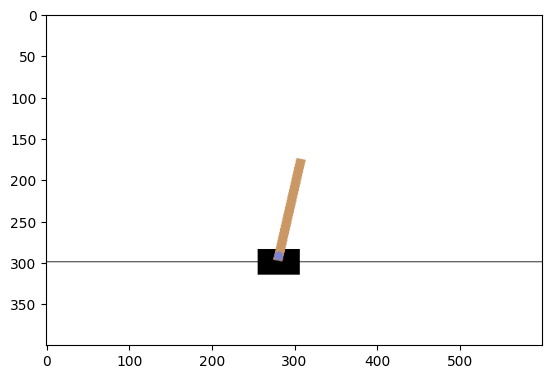

In [33]:
import gym
import numpy as np
import cv2

def resize_images(images, new_width=150, new_height=100):
    resized_images = []
    for img in images:
        # Utiliser INTER_AREA pour un meilleur résultat lors du redimensionnement vers le bas
        resized = cv2.resize(img, (new_width, new_height))
        resized_images.append(resized)
    return resized_images

env = gym.make('CartPole-v1')
observations = []
images = []

for ep in range(10):  # Collecter 1000 étapes
    env.reset()
    for t in range(200):  # Maximum de 200 étapes par épisode
        action = env.action_space.sample()  # Choisir une action aléatoire
        obs, _, done, _ = env.step(action)
        img = env.render(mode ='rgb_array')
        observations.append(obs)
        images.append(img)
        if done:
            plt.imshow(img)
            break

# Vous pouvez sauvegarder ces données pour une utilisation ultérieure
# np.save('observations.npy', observations)
# np.save('images.npy', images)


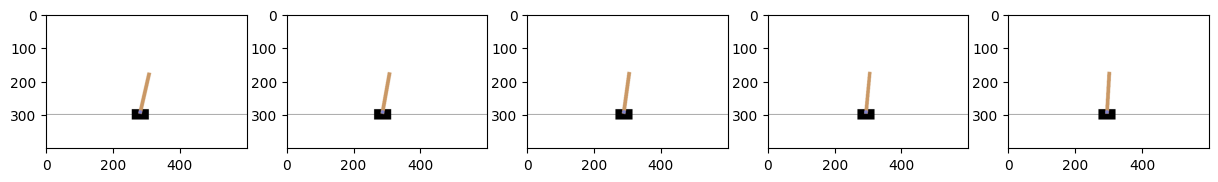

In [40]:
n_images = 5  
fig, axes = plt.subplots(1, n_images, figsize=(15, 5))  # Crée une figure et des axes avec 1 ligne et 'n_images' colonnes

for i in range(n_images):
    # Affiche l'image en position -i-1 pour obtenir les 5 dernières images en ordre inverse
    ax = axes[i]
    img = images[-i-1]
    ax.imshow(img)

plt.show()


(400, 600, 3)
[ 0.00488783 -0.14782073 -0.03024808  0.3089195 ]


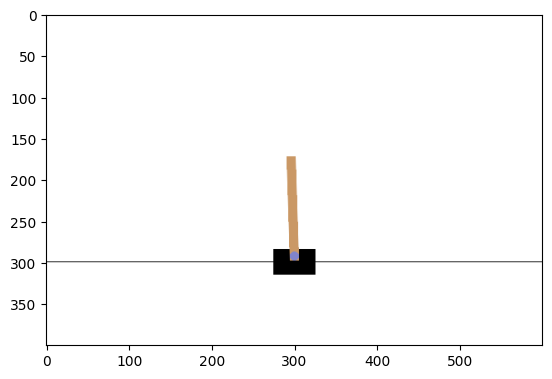

In [43]:
print(images[0].shape)
print(observations[0])
plt.imshow(images[0])

In [2]:
import gym
images = []

env = gym.make('CartPole-v1')
for _ in range(10):
    env.reset()
    
    for _ in range(200):  # Nombre maximum de pas par épisode
        action = env.action_space.sample()  # Choix d'une action aléatoire
        obs, _, done, _ = env.step(action)
        img = env.render(mode='rgb_array')
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img = cv2.resize(img, (224, 224))
        images.append(img)
        if done:
            break

  

NameError: name 'cv2' is not defined

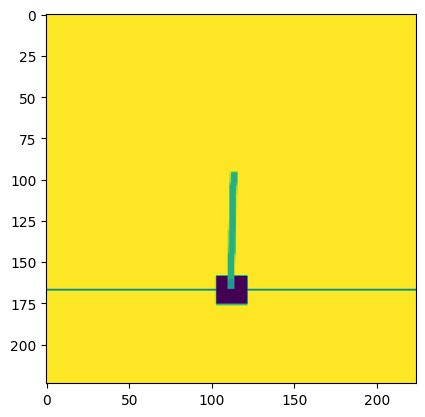

: 

In [70]:
plt.imshow(images[154])

In [2]:
import gym
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import Compose, ToTensor, Grayscale, Resize
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [30]:
# Initialisation de l'environnement Gym
env = gym.make('CartPole-v1')

# Fonction pour prétraiter une image
def preprocess_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Convertir en gris
    image = cv2.resize(image, (164, 164))  # Redimensionner
    return image

# Transformer les images et les convertir en tenseurs
transform = Compose([
    ToTensor(),
    Resize((164, 164)),
    Grayscale()
])

# Collecter les données
def collect_data(env, episodes, timesteps):
    data = []
    labels = []
    for episode in range(episodes):
        observation = env.reset()
        images = []
        for t in range(timesteps):
            image = env.render(mode='rgb_array')
            image = preprocess_image(image)
            images.append(image)
            if len(images) < 4:
                # Remplir avec des images noires si moins de 4 images sont disponibles
                padded_images = images + [np.zeros((164, 164))] * (4 - len(images))
            else:
                # Si nous avons 4 ou plus, utiliser les dernières 4 images
                padded_images = images[-4:]
                
            input_images = np.stack(padded_images, axis=0)
            data.append(input_images)
            labels.append(observation)  # Observation est le label (état du système)

            observation, reward, done, info = env.step(env.action_space.sample())  # prendre une action aléatoire
            if done:
                break
    return np.array(data), np.array(labels)


# Collecter des données
data, labels = collect_data(env, 30, 100)  # 100 épisodes, 100 pas par épisode

# Convertir les données en tenseurs PyTorch
tensor_data = torch.tensor(data, dtype=torch.float32)
tensor_labels = torch.tensor(labels, dtype=torch.float32)

# Création d'un DataLoader
dataset = TensorDataset(tensor_data, tensor_labels)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

#(400, 600, 3)


torch.Size([10, 4]) torch.Size([10, 4, 164, 164])
AxesImage(shape=(164, 164)) tensor([-0.0189, -0.0194, -0.0417, -0.0612])
AxesImage(shape=(164, 164)) tensor([ 0.0151, -0.0267, -0.0417,  0.0261])


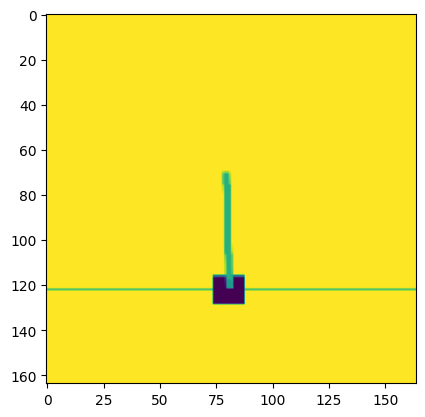

In [36]:
for images, labels in dataloader:
    print(labels.shape,images.shape)
    print(plt.imshow(images[0][0]), labels[0])
    print(plt.imshow(images[0][2]), labels[2])

    break

In [37]:
class CartPoleCNN(nn.Module):
    def __init__(self):
        super(CartPoleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(4, 16, kernel_size=5, stride=1, padding=2),  # Input: 4 gray images, output: 16 channels
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # Output size: 112x112  OU 100x150 
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # Output size: 56x56 OU 50x75 
            # nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2)                  # Output size: 28x28 OU 50x75 OU 25x25
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(32 * 41 * 41, 128),
            nn.ReLU(),
            nn.Linear(128,4)    # x, x_dot, theta, theta_dot
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layers
        x = self.fc_layers(x)
        return x

# Instanciation du modèle
model = CartPoleCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [38]:
def train(model, dataloader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        for images, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Entraînement du modèle
train(model, dataloader, criterion, optimizer, epochs=10)


Epoch 1, Loss: 0.2962365746498108
Epoch 2, Loss: 0.1342073529958725
Epoch 3, Loss: 0.14233556389808655
Epoch 4, Loss: 0.11451870948076248
Epoch 5, Loss: 0.07716383039951324
Epoch 6, Loss: 0.09452163428068161
Epoch 7, Loss: 0.08022332191467285
Epoch 8, Loss: 0.0284079909324646
Epoch 9, Loss: 0.07467210292816162
Epoch 10, Loss: 0.10892213135957718


In [39]:
Images=[]
observations=[]
for ep in range(1):  # Collecter 1000 étapes
    env.reset()
    for t in range(200):  # Maximum de 200 étapes par épisode
        action = env.action_space.sample()  # Choisir une action aléatoire
        obs, _, done, _ = env.step(action)
        img = env.render(mode ='rgb_array')
        img = preprocess_image(img)
        
        observations.append(obs)
        Images.append(img)
        if done:
            break



In [40]:
for images, labels in dataloader:
    print(model(images), labels)
    break


tensor([[ 0.1732,  0.0157, -0.0208,  0.2227],
        [ 0.2367,  1.1680, -0.0860, -1.2668],
        [ 0.3319,  0.4082, -0.1064, -0.2426],
        [-0.2633,  0.2215,  0.0069,  0.0190],
        [ 0.2817,  0.2985, -0.0346, -0.1270],
        [ 0.1805, -0.4313,  0.0748,  0.8894],
        [ 0.1757,  0.0238,  0.0382,  0.5550],
        [ 0.3462,  0.7358, -0.0262, -0.6041],
        [ 0.2115,  0.0232, -0.0249,  0.1434],
        [ 0.2975,  0.8808, -0.2382, -1.1151]], grad_fn=<AddmmBackward0>) tensor([[-4.3732e-02,  1.7952e-01,  8.4046e-02, -7.6469e-02],
        [ 3.0715e-02,  1.1785e+00, -3.0355e-02, -1.7028e+00],
        [ 5.1962e-02,  4.2667e-01,  7.7866e-03, -5.0787e-01],
        [ 2.7994e-02, -2.3740e-01,  3.8850e-02,  2.8253e-01],
        [-3.5208e-02,  2.2592e-01, -2.6077e-04, -2.9427e-01],
        [-9.3987e-02, -5.8648e-01,  6.9741e-02,  8.6963e-01],
        [-8.8704e-03, -2.4127e-01,  1.8024e-01,  1.2939e+00],
        [-4.7209e-03,  7.8848e-01,  2.0297e-02, -1.1232e+00],
        [-3.6319e

: 

In [53]:
input_images = np.stack(Images[0:4], axis=0)
input_images = torch.tensor(np.expand_dims(input_images,axis=0))
print(input_images.shape)
print(model(input_images),observations[0])

torch.Size([1, 4, 224, 224])


RuntimeError: Input type (unsigned char) and bias type (float) should be the same